In [11]:
! pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dengue_df = pd.read_csv('../assets/sg_dengue_w_weather_df.csv')

#dengue_df = pd.read_csv('../content/drive/MyDrive/DSIF-12_project_4/assets/sg_dengue_w_weather_df.csv')

In [3]:
dengue_df.set_index(dengue_df['Date'], inplace = True)

dengue_df.drop(columns='Date',inplace = True)

dengue_df.head()

,Year,eWeek,Cases,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Year_eWeek,Month,Year_Month,Search Interest,Mean Wind Speed (km/h)_W-6,Weekly Rainfall Total (mm)_W-2,Mean Temperature (°C)_W-3,Search Interest_W-2
Date,,,,,,,,,,,,,,,,,,,,
2014-01-06,2014,1,437.0,12.967797,8.641818,10.209091,11.001818,26.932018,31.615,25.110,8.771250,38.394737,2014-1,12,2014-12,48,NaN,NaN,NaN,NaN
2014-01-13,2014,2,479.0,57.510169,12.750909,15.549091,18.998182,26.333960,32.165,24.705,7.247024,40.494737,2014-2,1,2014-1,60,NaN,NaN,NaN,NaN
2014-01-20,2014,3,401.0,2.672881,2.320000,2.418182,2.432727,26.321053,30.255,25.000,12.207857,43.347368,2014-3,1,2014-1,60,NaN,12.967797,NaN,48.0
2014-01-27,2014,4,336.0,0.000000,0.000000,0.000000,0.000000,25.869173,30.035,23.880,12.107857,41.184211,2014-4,1,2014-1,42,NaN,57.510169,26.932018,60.0
2014-02-03,2014,5,234.0,0.000000,0.000000,0.000000,0.000000,26.200902,32.530,24.240,12.105714,42.563158,2014-5,1,2014-1,41,NaN,2.672881,26.333960,60.0


In [4]:
dengue_cases_df =pd.DataFrame()
dengue_cases_df['Cases'] = dengue_df[['Cases']]
dengue_cases_df['Lag_1'] = dengue_df[['Cases']].shift(1)
dengue_cases_df['Lag_4'] = dengue_df[['Cases']].shift(4)
dengue_cases_df['Lag_12'] = dengue_df[['Cases']].shift(12)
dengue_cases_df['Lag_14'] = dengue_df[['Cases']].shift(14)
dengue_cases_df['Lag_28'] = dengue_df[['Cases']].shift(28)
dengue_cases_df['lag_51'] = dengue_df[['Cases']].shift(51)
dengue_cases_df.corr()

,Cases,Lag_1,Lag_4,Lag_12,Lag_14,Lag_28,lag_51
Cases,1.000000,0.961958,0.843349,0.520924,0.465108,0.435197,0.214887
Lag_1,0.961958,1.000000,0.886554,0.550750,0.492533,0.445023,0.201202
Lag_4,0.843349,0.886554,1.000000,0.653575,0.585135,0.431028,0.140125
Lag_12,0.520924,0.550750,0.653575,1.000000,0.924114,0.413935,0.111957
Lag_14,0.465108,0.492533,0.585135,0.924114,1.000000,0.450194,0.148637
Lag_28,0.435197,0.445023,0.431028,0.413935,0.450194,1.000000,0.375902
lag_51,0.214887,0.201202,0.140125,0.111957,0.148637,0.375902,1.000000


### Modeling

#### Train/Test Split

In [5]:
# What index gives us our 75th percentile of rows?
dengue_df.shape[0] * (75/100)

195.0

In [6]:
dengue_df.shape

(260, 20)

In [7]:
train = dengue_df.iloc[0:195]

test = dengue_df.iloc[195:]

In [10]:
# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(train['Cases']))

Test Statistic   -2.192188
p-value           0.209093
dtype: float64

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Our p -values is more than 0.05, thus we fail to reject the null hypothesis. The data has a unit root and is non-stationary. We need to perform differenting.

In [11]:
#We'll start with a difference of  to see if the time series first_diff is stationary.
interpret_dftest(adfuller(train['Cases'].diff().dropna()))

Test Statistic   -1.407968e+01
p-value           2.843436e-26
dtype: float64

Yes, it is stationary as the p-value is less than 0.05.

### Auto ARIMA

### Plot ACF & PACF

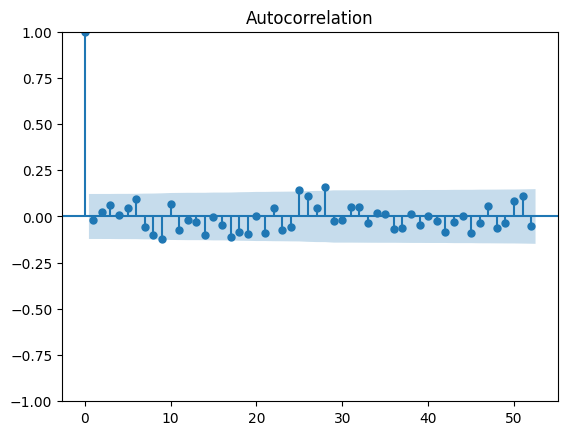

In [41]:
plot_acf(dengue_df['Cases'].diff().dropna(), lags = 52);

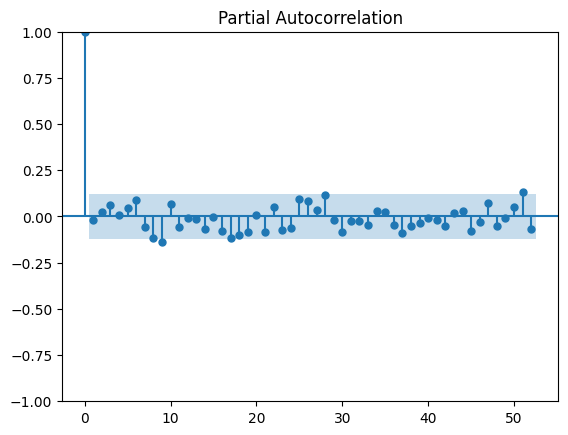

In [42]:
plot_pacf(dengue_df['Cases'].diff().dropna(), lags = 52);

The ACF plot shows the correlation of a time series with itself at different lags, while the PACF plot shows the correlation of a time series with itself at different lags, after removing the effects of the previous lags.

Based on PACF, we should start with the S with either 28 or 51

In [73]:


train = train['Cases']

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(train,
                      m=28,               # frequency of series 51 or 52
                      seasonal=True,      # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[28] intercept   : AIC=inf, Time=7.53 sec
 ARIMA(0,1,0)(0,0,0)[28] intercept   : AIC=2071.911, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[28] intercept   : AIC=2068.659, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[28] intercept   : AIC=2066.456, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[28]             : AIC=2070.239, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[28] intercept   : AIC=2073.859, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[28] intercept   : AIC=2065.983, Time=1.70 sec
 ARIMA(0,1,1)(1,0,0)[28] intercept   : AIC=2068.661, Time=0.97 sec
 ARIMA(0,1,1)(2,0,1)[28] intercept   : AIC=inf, Time=13.10 sec
 ARIMA(0,1,1)(1,0,2)[28] intercept   : AIC=2067.964, Time=13.68 sec
 ARIMA(0,1,1)(0,0,2)[28] intercept   : AIC=2066.681, Time=4.53 sec
 ARIMA(0,1,1)(2,0,0)[28] intercept   : AIC=2068.735, Time=4.29 sec
 ARIMA(0,1,1)(2,0,2)[28] intercept   : AIC=inf, Time=16.51 sec
 ARIMA(0,1,0)(1,0,1)[28] intercept   : AIC=2064.065, Time=1.26 sec
 ARIMA(0,1,0)(0,0,1)[28] interc

The best model is SARIMA (0,1,0)(1,0,1,28)

In [8]:
order = (0,1,0)
seasonal_order = (1,0,1,28)

In [9]:
sarima = SARIMAX(endog = train['Cases'],
            order = order, # (p, d, q)
            seasonal_order = seasonal_order ) # (P, D, Q, S)

model = sarima.fit()


preds_auto_arima_train = model.predict(start=0, end=194)

preds_auto_arima_test = model.predict(start=196, end=260)


C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [10]:
# Evaluate predictions.
train_rmse = mean_squared_error(train["Cases"], preds_auto_arima_train , squared = False)

test_rmse = mean_squared_error(test["Cases"], preds_auto_arima_test , squared = False)

print(f'Train RMSE:{train_rmse}')
print(f'Test RMSE:{test_rmse}')

Train RMSE:57.948047372867265
Test RMSE:26.035337378496855


In [11]:
def show_plot(preds):
    # Reset index to convert it into a column
    train_reset = train.reset_index()
    test_reset = test.reset_index()

    # Convert the 'Date' column to datetime if it's not already
    train_reset['Date'] = pd.to_datetime(train_reset['Date'])
    test_reset['Date'] = pd.to_datetime(test_reset['Date'])

    # Set the 'Date' column as index again
    train_reset.set_index('Date', inplace=True)
    test_reset.set_index('Date', inplace=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(train_reset['Cases'], color='blue', label='Train')
    plt.plot(test_reset['Cases'], color='orange', label='Test')
    plt.plot(preds, color='green', label='Prediction')
    plt.title('Weekly Sales Prediction with SARIMA', fontsize=18)
    plt.legend()
    plt.show()

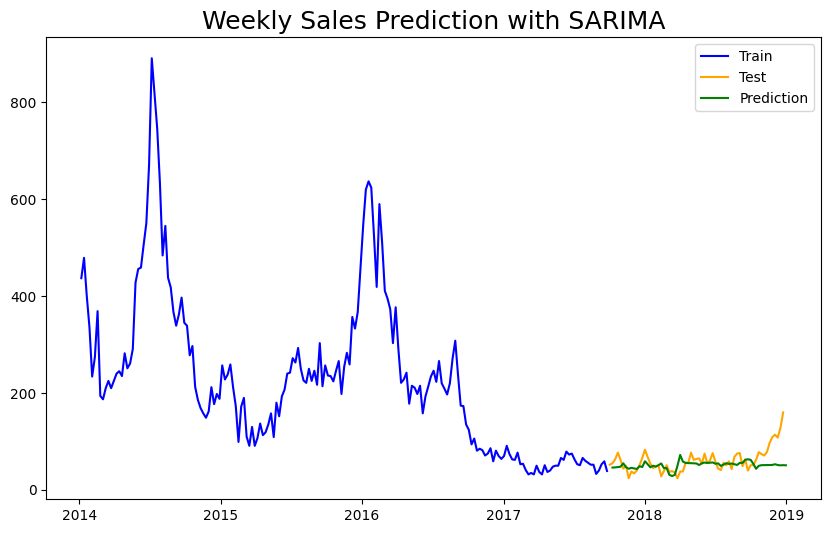

In [12]:
show_plot(preds_auto_arima_test)

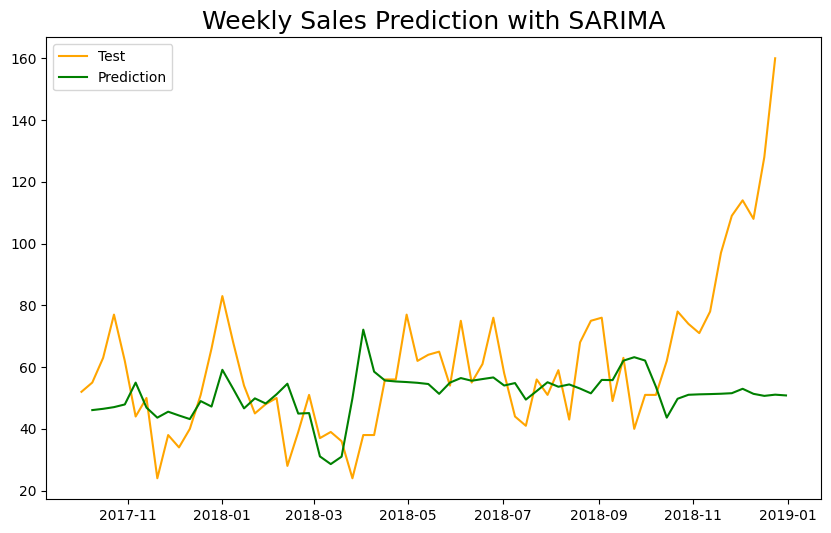

In [15]:
# Plot the data

train_reset = train.reset_index()
test_reset = test.reset_index()

    # Convert the 'Date' column to datetime if it's not already
train_reset['Date'] = pd.to_datetime(train_reset['Date'])
test_reset['Date'] = pd.to_datetime(test_reset['Date'])

    # Set the 'Date' column as index again
train_reset.set_index('Date', inplace=True)
test_reset.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))

plt.plot(test_reset['Cases'], color='orange', label='Test')
plt.plot(preds_auto_arima_test, color='green', label='Prediction')
plt.title('Weekly Sales Prediction with SARIMA', fontsize=18)
plt.legend()
plt.show()

### Rolling Window

In [24]:
def rolling_predictions(order,seasonal_order):
    tscv = TimeSeriesSplit(n_splits = 5)
    all_preds = []
    all_periods = []
    
    for train_index, test_index in tscv.split(dengue_df['Cases']):
        cv_train, cv_test = dengue_df['Cases'].iloc[train_index], dengue_df['Cases'].iloc[test_index]
        
        sarima = SARIMAX(endog = cv_train,
                order = order, # (p, d, q)
                seasonal_order = seasonal_order,
                initialization='approximate_diffuse') # (P, D, Q, S)
    
        # Fit AR(1) model.
        model = sarima.fit(disp=False)
    
    
        preds = model.predict(cv_test.index.values[0], cv_test.index.values[-1])

        preds_train = model.predict(cv_train.index.values[0], cv_train.index.values[-1])
        all_preds.extend(preds)

        periods = pd.date_range(start=cv_test.index[0], end=cv_test.index[-1], freq='W')
        all_periods.extend(periods)
    
        # Evaluate predictions.
        rmse_train = mean_squared_error(cv_train.values, preds_train , squared = False)

        # Evaluate predictions.
        rmse = mean_squared_error(cv_test.values, preds , squared = False)
        print(f'Train RMSE:{rmse_train}')

        print(f'Test RMSE:{rmse}')
    
    
    return all_periods,all_preds


C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Train RMSE:98.08163589016408
Test RMSE:187.02970630641653


C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Train RMSE:74.53184815888761
Test RMSE:107.57528635896313


C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Train RMSE:69.34215754137266
Test RMSE:114.28068231187476


C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Train RMSE:61.62783256610756
Test RMSE:25.067991790315446


C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Jia Hui\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Train RMSE:55.42406283004251
Test RMSE:31.052608888242684


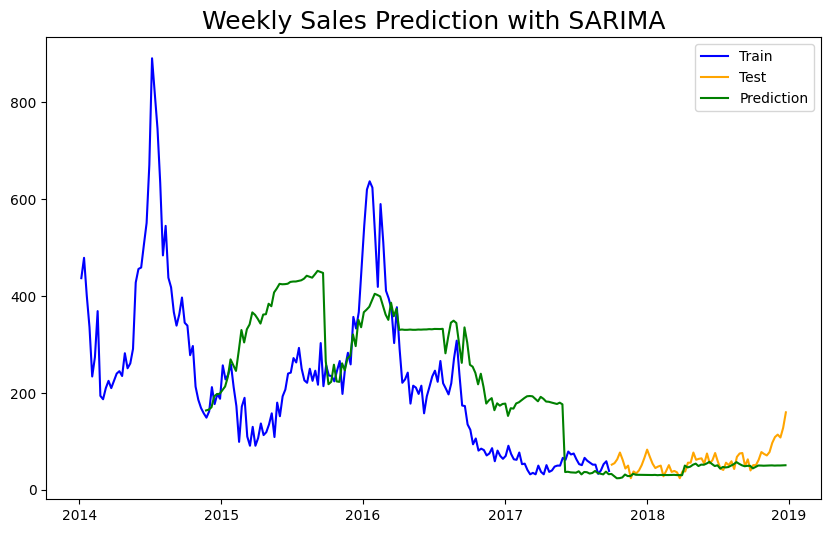

In [25]:
# Assuming `train_reset`, `test_reset`, and `preds` are defined
all_periods, all_preds = rolling_predictions(order, seasonal_order)
all_periods, all_preds = all_periods[:210], all_preds[:210]

# Reset index to convert it into a column
train_reset = train.reset_index()
test_reset = test.reset_index()

# Convert the 'Date' column to datetime if it's not already
train_reset['Date'] = pd.to_datetime(train_reset['Date'])
test_reset['Date'] = pd.to_datetime(test_reset['Date'])

# Set the 'Date' column as index again
train_reset.set_index('Date', inplace=True)
test_reset.set_index('Date', inplace=True)
    

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(train_reset['Cases'], color='blue', label='Train')
plt.plot(test_reset['Cases'], color='orange', label='Test')
plt.plot(all_periods, all_preds, color='green', label='Prediction')
plt.title('Weekly Sales Prediction with SARIMA', fontsize=18)
plt.legend()
plt.show()


Time series data often exhibits changing patterns and behaviors over time. By using a rolling window approach, the model can adapt to these changes by continuously updating and retraining on the most recent data.The Performance of the model does improve over time.